<h2><b>Main task analysis - including outliers</b></h2>
<p>Takes the summary table from the task analysis and tests H1a - <b>regressive errors are reduced and perseverative errors are increased in disgust learning</b></p>
<p>Exactly the same as the analyses done in the 'excluding outliers' version but with outliers included</p>
<p> Includes:</p>
<li>Hypothesis testing
<li>Model assumption tests 
<li>Adding covariates
<li>Adding video rating scores
<br>
<p>NB this current version is run on fake data - randomly generated so won't see any expected effects

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
from statannotations.Annotator import Annotator
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PowerTransformer

from dataclean_func import *
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

ModuleNotFoundError: No module named 'statannotations'

In [7]:
pip install statannotations

  Using cached statannotations-0.6.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached seaborn-0.11.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached pandas-1.5.3.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached statannotations-0.6.0-py3-none-any.whl (32 kB)
Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
Failed to build pandas
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2517 lines of output]
      <string>:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\pandas
      copying pandas\conftest.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\testing.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\_typing.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\_version.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\__init__.py -> build\lib.win-amd64-cpython-312\pandas
      creating build\lib.win-amd64-cpython-312\pandas\api
      copying pandas\api\__init__.py -> build\lib.win-amd64-cpython-312\pandas\a

In [128]:
task_summary=pd.read_csv('csvs/task_summary_dummy.csv')
#df.drop(['Unnamed: 0', 'index'], axis="columns", inplace=True)

<h3><b>Main hypothesis test</b></h3>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 1) 'mean_perseverative_er ~ block_type + age + sex + digit span'
<li>2) 'mean_regressive_er ~ block_type + age + sex + digit_span'

<b> MODEL 1: PERSEVERATIVE ERRORS </b>

Firstly - check the outcome for skewness

In [ ]:
sns.histplot(data=task_summary, x="mean_perseverative_er") 
print('Perseverative error skew: '+str(skew(task_summary.mean_perseverative_er)))

Now run the initial hypothesis testing model

In [ ]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

If covariates (age, sex, working memory) are not significant, remove them from the analysis in order to maximise power.

In [ ]:
#e.g., if only working memory and sex have significant effects, remove age as a covariate
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

In [ ]:
##Follow-up pairwise comparisons
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']
annotator = Annotator(axes, pairs, data=task_summary, x='block_type', y='regressive_er_transformed', order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
annotator.apply_and_annotate()

Test the assumptions of this final model

In [ ]:
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

In [ ]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

<b> MODEL 2: REGRESSIVE ERRORS </b>
<p> Same again - this time I have made the outcome variable skewed so show how this would be dealth with </p>

Firstly - check the outcome for skewness

Regressive error skew: 1.3644511121614604


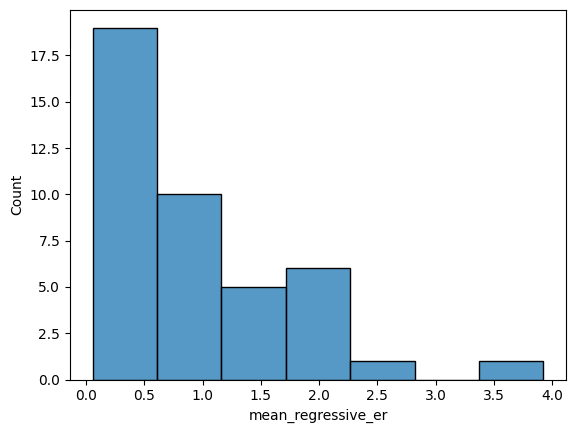

In [129]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution
sns.histplot(data=task_summary, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary.mean_regressive_er)))

Given that the distribution was skewed, must perform a transformation

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

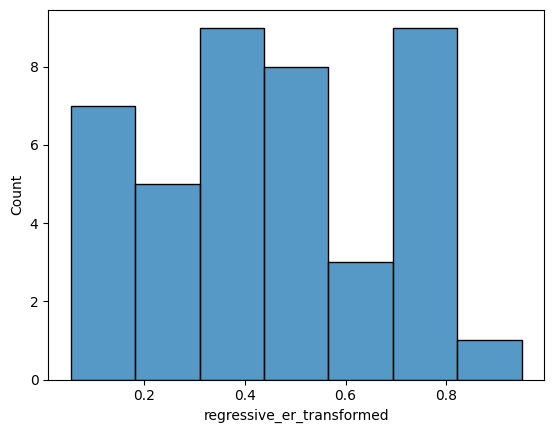

In [142]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
task_summary['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
sns.histplot(data=task_summary['regressive_er_transformed'])

Now run the hypothesis testing model on the transformed variable

In [239]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 42      Method:             REML                     
No. Groups:       14      Scale:              0.0528                   
Min. group size:  3       Log-Likelihood:     -10.7449                 
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.494     0.157   3.150  0.002   0.187   0.801
prolific_sex[T.Male]      0.134     0.092   1.456  0.146  -0.046   0.314
block_type               -0.026     0.043  -0.594  0.552  -0.111   0.059
prolific_age              0.000     0.004   0.094  0.925  -0.007   0.008
di

If covariates (age, sex, working memory) are not significant, remove them from the analysis in order to maximise power.

In [230]:
#e.g., if only working memory and sex have significant effects, remove age as a covariate
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 42      Method:             REML                     
No. Groups:       14      Scale:              0.0528                   
Min. group size:  3       Log-Likelihood:     -6.0687                  
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.504     0.112   4.513  0.000   0.285   0.723
prolific_sex[T.Male]      0.137     0.082   1.670  0.095  -0.024   0.298
block_type               -0.026     0.043  -0.594  0.552  -0.111   0.059
digit_span               -0.018     0.015  -1.186  0.236  -0.048   0.012
Gr

In [ ]:
##Follow-up pairwise comparisons
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']
annotator = Annotator(axes, pairs, data=task_summary, x='block_type', y='regressive_er_transformed', order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
annotator.apply_and_annotate()

Test the assumptions of this final model

Statistic 0.9743844267574068
p-value 0.4578887654947099


Text(0.5, 1.0, 'Q-Q Plot')

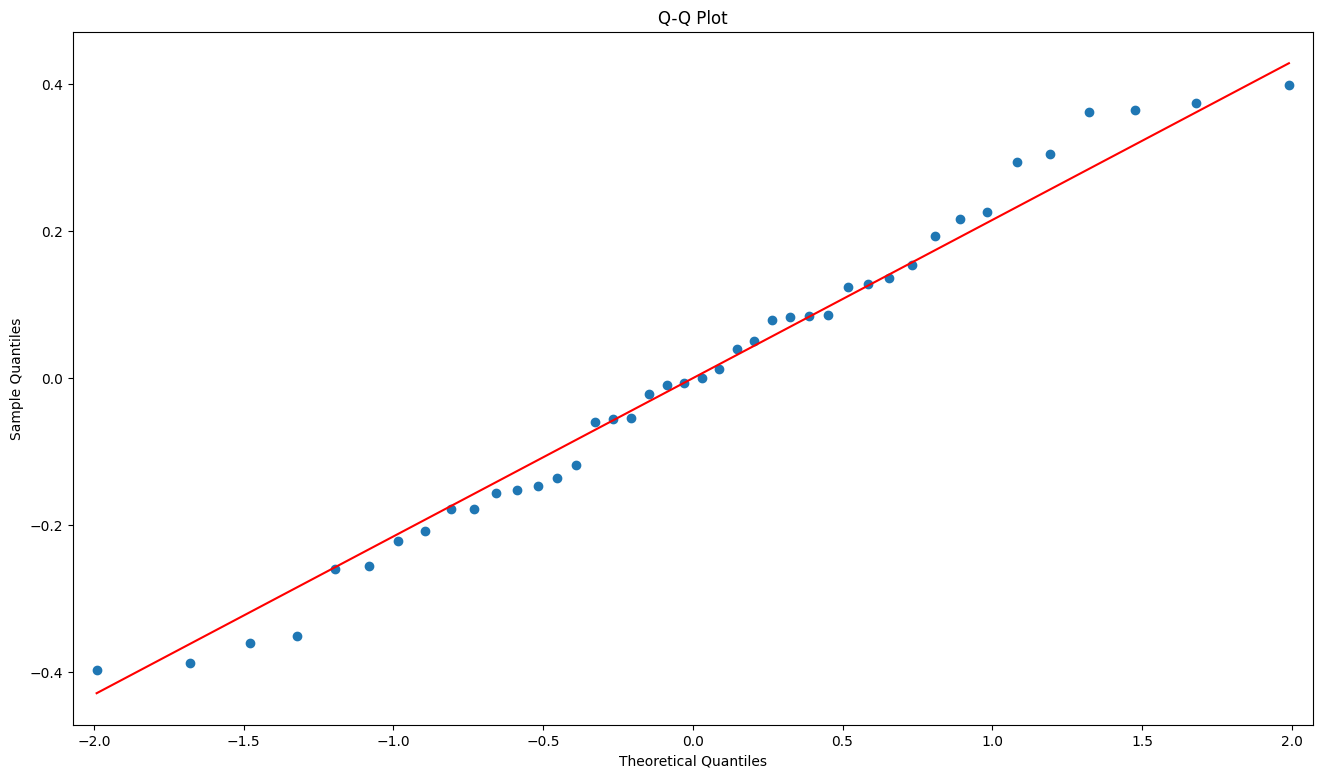

In [231]:
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

LM Statistic 1.2185049132310817
LM-Test p-value 0.5437571992779221
F-Statistic 0.5826379282429747
F-Test p-value 0.5632097089972934


Text(0, 0.5, 'Residuals')

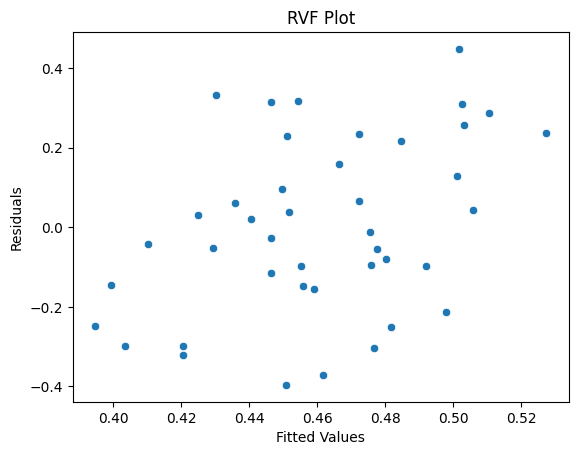

In [167]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

<h3><b>Adding video ratings</b></h3>
<p>Testing whether this result is modified by adding video ratings: </p>
<p>=models 3 and 4 in the analysis plan
<p><b>ONLY TO BE RUN IF RESULTS OF VIDEO RATINGS WARRANT IT</b>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T2-T1) - Disgust(T2-T1))

Firstly calculate the relevant values and add to the dataframe

In [206]:
##add these values to the dataframe
chosen_stim_df = pd.read_csv("csvs/chosen_stim_dummy.csv")
stim_ratings_covariates=pd.DataFrame()
for participant_no in set(chosen_stim_df.participant_no):
    participant_df=chosen_stim_df[chosen_stim_df.participant_no==participant_no]
    disgust=participant_df[participant_df.trial_type=="disgust"]
    fear=participant_df[participant_df.trial_type=="fear"]
    #difference scores
    valence_diff=int(fear.unpleasant_1)-int(disgust.unpleasant_1)
    arousal_diff=int(fear.arousing_1)-int(disgust.arousing_1)

    #habituation scores
    valence_habdiff=(int(fear.unpleasant_1)-int(fear.unpleasant_2))-(int(disgust.unpleasant_1)-int(disgust.unpleasant_2))
    arousal_habdiff=(int(fear.arousing_1)-int(fear.arousing_2))-(int(disgust.arousing_1)-int(disgust.arousing_2))
    
    row=pd.DataFrame({
        'participant_no': [participant_no],
        'valence_diff': [valence_diff],
        'arousal_diff': [arousal_diff],
        'valence_habdiff': [valence_habdiff],
        'arousal_habdiff': [arousal_habdiff],
    })
    stim_ratings_covariates=pd.concat([stim_ratings_covariates, row])
task_and_ratings_summary=pd.merge(task_summary, stim_ratings_covariates, on='participant_no', how='outer')

Now add to the mixed effects models: again only running models that are necessary (determined in the video_ratings_analysis)
<p><b>Start with perseverative errors (model 3)</b></p>

<b> MODEL 3: PERSEVERATIVE ERRORS W VIDEO RATINGS </b>

In [ ]:
#e.g., if there was a difference in valence habituation and baseline arousal
# identified by a difference in valence habituation (valence_habdiff)
        #i.e., a time*stimulus type interaction in valence model (model A)
# and an effect of stimulus type in arousal model (model B)

data=task_and_ratings_summary
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type + prolific_age + prolific_sex + digit_span + arousal_diff + valence_habdiff'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

In [ ]:
##Follow-up pairwise comparisons
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']
annotator = Annotator(axes, pairs, data=task_summary, x='block_type', y='regressive_er_transformed', order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
annotator.apply_and_annotate()

In [ ]:
#again checking assumptions
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

<b> MODEL 4: REGRESSIVE ERRORS W VIDEO RATINGS </b>

Now add to the mixed effects models: again only running models that are necessary (determined in the video_ratings_analysis)

In [232]:
#e.g., same scenario as above
#note still using transformed outcome variable

data=task_and_ratings_summary
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type + prolific_age + prolific_sex + digit_span + arousal_diff + valence_habdiff'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_regressive_er
No. Observations: 42      Method:             REML              
No. Groups:       14      Scale:              0.5888            
Min. group size:  3       Log-Likelihood:     -58.4021          
Max. group size:  3       Converged:          Yes               
Mean group size:  3.0                                           
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.492    0.500  2.984 0.003  0.512  2.473
prolific_sex[T.Male]   0.584    0.280  2.087 0.037  0.036  1.132
block_type            -0.100    0.145 -0.692 0.489 -0.385  0.184
prolific_age          -0.018    0.013 -1.381 0.167 -0.043  0.007
digit_span            -0.010    0.055 -0.189 0.850 -0.118  0.097
arousal_diff           0.076    0.038  

In [ ]:
##Follow-up pairwise comparisons
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']
annotator = Annotator(axes, pairs, data=task_summary, x='block_type', y='regressive_er_transformed', order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
annotator.apply_and_annotate()

In [233]:
#again checking assumptions
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9461051724663839
p-value 0.04689778333501694
LM Statistic 19.084389308194986
LM-Test p-value 0.5163468581449223
F-Statistic 0.8744523130151997
F-Test p-value 0.6164046854122611


<h3><b>Win-stay/lose-shift analyses</b></h3>
<p>Only to be run if there are differences in regressive or perseverative errors across the block types (significant effects of block type in models 1 or 2)</p>
<p>Models to run: </p>
<li> 5) 'win_stay ~ block_type + any covariates that were significant in models 1-4'
<li> 6) 'lose_shift ~ block_type + any covariates that were significant in models 1-4'

<b> MODEL 5: WIN-STAY </b>

In [ ]:
sns.histplot(data=task_summary, x="win-stay") 
print('Win-stay  skew: '+str(skew(task_summary.win_stay)))

Now run the hypothesis testing model (with any covariates that were significant in models 1-4)

In [ ]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'win_stay ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

In [ ]:
##Follow-up pairwise comparisons
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']
annotator = Annotator(axes, pairs, data=task_summary, x='block_type', y='regressive_er_transformed', order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
annotator.apply_and_annotate()

Test the assumptions of this model

In [ ]:
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

In [ ]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

<b> MODEL 6: LOSE-SHIFT </b>

In [ ]:
sns.histplot(data=task_summary, x="lose-shift") 
print('lose-shift  skew: '+str(skew(task_summary.win_stay)))

Now run the hypothesis testing model (with any covariates that were significant in models 1-4)

In [ ]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'lose_shift ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

In [ ]:
##Follow-up pairwise comparisons
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']
annotator = Annotator(axes, pairs, data=task_summary, x='block_type', y='regressive_er_transformed', order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
annotator.apply_and_annotate()

Test the assumptions of this model

In [ ]:
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

In [ ]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

<h3><b>Sensitivity analysis</b></h3>
<p>Are any of these outcomes influenced/modified by the presence of outliers?</p>
<p>side note: if model assumptions are violated, this is one way of improving it

In [222]:
#create outliers df --> removing those >1.5 IQRs above or below UQ and LQ
task_summary_nooutliers=task_summary.copy()
for col in task_summary_nooutliers.select_dtypes(include=np.number).columns:
    task_summary_nooutliers=replace_outliers_with_nan(task_summary_nooutliers, col)

#check for outliers
task_summary_nooutliers[task_summary_nooutliers.isna().any(axis=1)]

,Unnamed: 0,percentage_correct,mean_perseverative_er,mean_regressive_er,win_stay,lose_shift,block_no,block_type,disgust_block,fear_block,points_block,participant_no,prolific_age,prolific_sex,digit_span,regressive_er_transformed
25,25,0.684696,7.625754,NaN,9.265103,7.904819,2.0,Fear,0,1,0,9.0,25,Male,1,0.94931


Regressive error skew: 0.7441454483405977


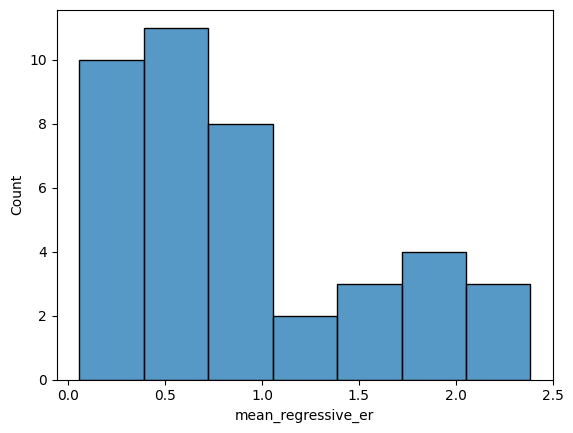

In [223]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution
sns.histplot(data=task_summary_nooutliers, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary_nooutliers.mean_regressive_er, nan_policy='omit')))

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

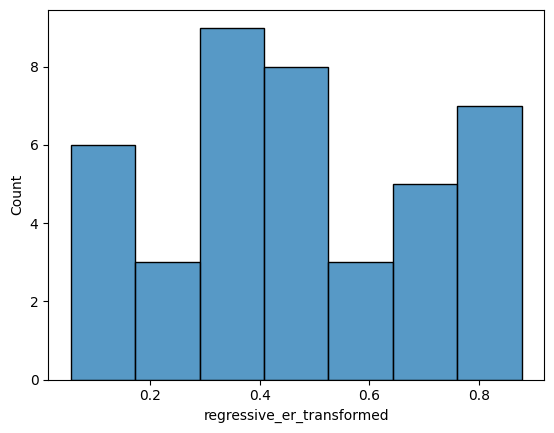

In [234]:
#Again, will need to transform
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary_nooutliers.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary_nooutliers.mean_regressive_er))
task_summary_nooutliers['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary_nooutliers.mean_regressive_er))
sns.histplot(data=task_summary_nooutliers['regressive_er_transformed'])

In [236]:
#and then the ultimate version of the mixed effects model will be run
# i.e., with the covariates which were significant
#and with video ratings covariates that were necessary

#first add video ratings to the outliers excluded table
task_and_ratings_nooutliers=pd.merge(task_summary_nooutliers, stim_ratings_covariates, on='participant_no', how='outer')


data=task_and_ratings_nooutliers
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type + prolific_age + prolific_sex + digit_span + arousal_diff + valence_habdiff'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 41      Method:             REML                     
No. Groups:       14      Scale:              0.0550                   
Min. group size:  2       Log-Likelihood:     -16.8357                 
Max. group size:  3       Converged:          No                       
Mean group size:  2.9                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.557     0.157   3.545  0.000   0.249   0.865
prolific_sex[T.Male]      0.127     0.089   1.424  0.154  -0.048   0.302
block_type               -0.029     0.044  -0.650  0.516  -0.116   0.058
prolific_age             -0.003     0.004  -0.735  0.463  -0.011   0.005
di

In [237]:
#final assumptions test
#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9824468250671182
p-value 0.7673773803001056
LM Statistic 17.700238347757164
LM-Test p-value 0.6071476074234707
F-Statistic 0.7596746529831279
F-Test p-value 0.7277578869122696


U:\Documents\envs\reversal_learning_venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\eb08\AppData\Local\Temp\ipykernel_9248\479778254.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\eb08\AppData\Local\Temp\ipykernel_9248\479778254.py:27: UserWarning: set_ticklabel

Text(0.5, 1.0, 'Perseverative errors')

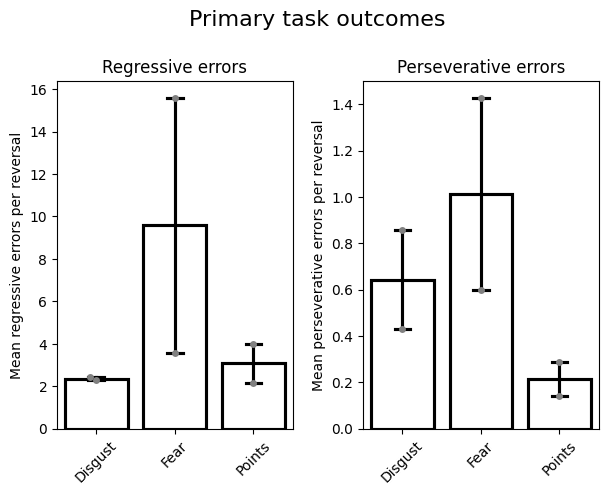

In [14]:
##Example plot
##plot hypothesised results
fig, axes = plt.subplots(1,2, sharey=False)
title="Primary task outcomes"
plt.suptitle(title, fontsize=16)
#fig.set_size_inches(15, 5)
fig.tight_layout(pad=2)
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']

n_comparisons=1
pvalue_thresholds=[0.0001/n_comparisons, "****"], [0.001/n_comparisons, "***"], [0.01/n_comparisons, "**"], [0.05/n_comparisons, "*"], [1, "ns"]

sns.swarmplot(data=df, x="block_type", y="mean_regressive_er", ax=axes[0], color=".5", size=5, )
sns.barplot(data=df, x="block_type", y="mean_regressive_er", ax=axes[0], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
#axes[0].set_xlabel("Feedback type")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel("Mean regressive errors per reversal") 
axes[0].set_title("Regressive errors") 


sns.swarmplot(data=df, x="block_type", y="mean_perseverative_er", ax=axes[1], color=".5", size=5)
sns.barplot(data=df, x="block_type", y="mean_perseverative_er", ax=axes[1], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
#axes[1].set_xlabel("Feedback type")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_ylabel("Mean perseverative errors per reversal") 
axes[1].set_title("Perseverative errors") 

C:\Users\eb08\AppData\Local\Temp\ipykernel_9248\4286203301.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  to_plot=df.replace(['Male', 'Female'], [0, 1])
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\eb08\AppData\Local\Temp\ipykernel_9248\4286203301.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Male", "Female"])


Text(695.0159143518518, 0.5, '')

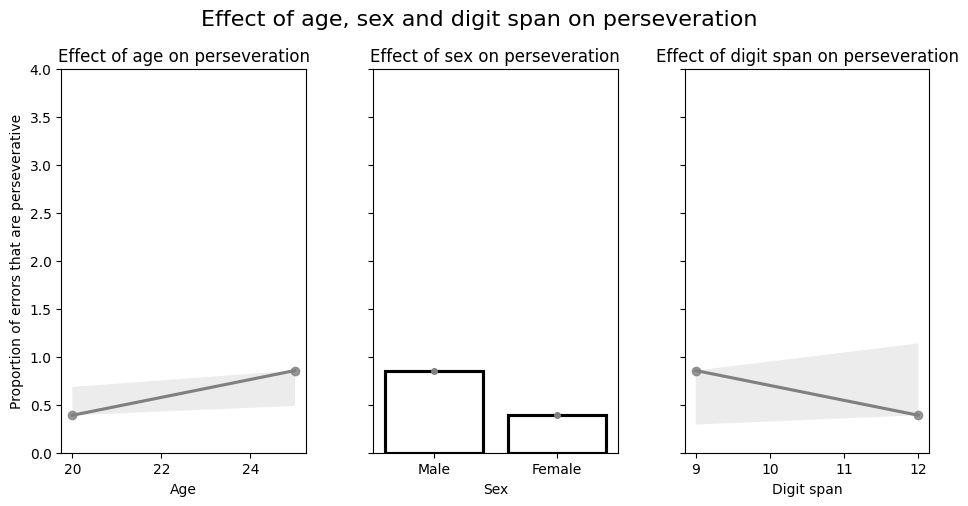

In [16]:
##example plot
to_plot=df.replace(['Male', 'Female'], [0, 1])
to_plot=to_plot.groupby('participant_no')[['mean_perseverative_er', 'lose_shift', 'digit_span', 'prolific_age', 'prolific_sex']].mean()

fig, axes = plt.subplots(1,3, sharey=True)
title="Effect of age, sex and digit span on perseveration"
plt.suptitle(title, fontsize=16)
fig.tight_layout(pad=1.5)
fig.set_size_inches(10, 5)
axes[0].set_ylim([0, 4])

sns.regplot(data=to_plot, x="prolific_age", y="mean_perseverative_er", ax=axes[0], color="0.5")
#r, p= scipy.stats.pearsonr(to_plot["prolific_age"], to_plot["mean_perseverative_er"])
#axes[0].text(21, 0.85, "R={}".format(round(r, ndigits=3)), backgroundcolor="0.7")
#axes[0].text(21, 0.78, "p={}".format(round(p, ndigits=3)), backgroundcolor="0.7")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Proportion of errors that are perseverative") 
axes[0].set_title("Effect of age on perseveration") 

sns.swarmplot(data=to_plot, x="prolific_sex", y="mean_perseverative_er", ax=axes[1], color=".5", size=5, )
sns.barplot(data=to_plot, x="prolific_sex", y="mean_perseverative_er", ax=axes[1], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
axes[1].set_xlabel("Sex")
axes[1].set_title("Effect of sex on perseveration") 
axes[1].set_ylabel("Proportion of errors that are perseverative") 
axes[1].set_xticklabels(["Male", "Female"])
pairs=[(0, 1)]
order=[0, 1]
#annotator = Annotator(axes[1], pairs, data=to_plot, x='prolific_sex', y='mean_perseverative_er', order=order)
#annotator.configure(test='t-test_ind', text_format='star', loc='inside', comparisons_correction="Bonferroni", hide_non_significant=False, pvalue_thresholds=pvalue_thresholds)
#annotator.apply_and_annotate()


to_plot_nonan=to_plot.dropna()
sns.regplot(data=to_plot_nonan, x="digit_span", y="mean_perseverative_er", ax=axes[2], color="0.5")
#r, p= scipy.stats.pearsonr(to_plot_nonan["digit_span"], to_plot_nonan["mean_perseverative_er"])
#axes[2].text(6, 0.85, "R={}".format(round(r, ndigits=3)), backgroundcolor="0.7")
#axes[2].text(6, 0.78, "p={}".format(round(p, ndigits=3)), backgroundcolor="0.7")
axes[2].set_xlabel("Digit span")
axes[2].set_title("Effect of digit span on perseveration") 
axes[2].set_ylabel("") 

<b>Win-stay/ lose-shift</b>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 'win_stay ~ block_type'
<li> 'lose_shift ~ block_type'
<p>(add any covariates that proved significant in main hypothesis testing? - or add covariates from the offset)</p>

In [20]:
#hypothesis test on lose shift
data=df.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'lose_shift ~ block_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lose_shift
No. Observations: 6       Method:             REML      
No. Groups:       2       Scale:              0.0110    
Min. group size:  3       Log-Likelihood:     1.4834    
Max. group size:  3       Converged:          Yes       
Mean group size:  3.0                                   
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.578     0.119  4.857  0.000   0.345   0.811
block_type  0.031     0.052  0.597  0.550  -0.071   0.134
Group Var   0.003     0.099                              



C:\Users\eb08\AppData\Local\Temp\ipykernel_9248\1958908476.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
#hypothesis test on win stay
data=df.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'win_stay ~ block_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: win_stay
No. Observations: 6       Method:             REML    
No. Groups:       2       Scale:              0.0078  
Min. group size:  3       Log-Likelihood:     1.5209  
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.817    0.127 6.450 0.000  0.569  1.066
block_type    0.031    0.044 0.695 0.487 -0.056  0.117
Group Var     0.014    0.307                          



C:\Users\eb08\AppData\Local\Temp\ipykernel_9248\4049596247.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
